### Sedaro Cosimulation Latency Benchmark

This notebook analyzes the latency and associated command rates achievable over a Sedaro cosimulation channel.  The current benchmarks assume that the data volumes are negligible but we can add a case for higher payload sizes if relevant to your use case.

**Notes:** Results may vary depending on location of client and server.

#### Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current work and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
  "API_KEY": "<API_KEY>"
}
```

This notebook also requires specific configuration of the HOST and SCENARIO_BRANCH_ID by defining them below or by
including the following in `config.json`

```json
{
  "HOST": "...",
  "LATENCY": {"SCENARIO_BRANCH_ID": "..."}
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.


#### Description of Test Set Up

To analyze the end-to-end latence of a Sedaro cosimulation channel, we will configure a simple cosimulator on the default SuperDove scenario that will read out ("consume") `estimatedMagneticFieldVector` state from a running simulation and publish ("produce") `attitude` Quaternions into the running simulation "per round".  In this configuration, consuming `estimatedMagneticFieldVector` state will block until an `attitude` is produced each round.  This creates a dependency between the two cosimulator transactions to best characterizes end-to-end latency.

#### Install Dependencies

In [ ]:
!pip install matplotlib numpy
!pip install "sedaro>=4.16.2"


#### Client Initialization

In [ ]:
import time
import os
from sedaro import SedaroApiClient
import json
import matplotlib.pyplot as plt
import numpy as np
import asyncio

# Optionally set the following variables here instead of in config.json
SCENARIO_BRANCH_ID = "" # ID of a SuperDove scenario
HOST = "" # Optionally use another sedaro instance as host

with open('../secrets.json', 'r') as file:
    api_key = json.load(file)['API_KEY']

try:
    with open('../config.json', 'r') as file:
        config = json.load(file)
        SCENARIO_BRANCH_ID = SCENARIO_BRANCH_ID or config['LATENCY']['SCENARIO_BRANCH_ID']
        HOST = HOST or config['HOST']
except FileNotFoundError:
    pass
except KeyError as e:
    raise KeyError(f"Missing key in config.json: {e}")
finally:
    assert SCENARIO_BRANCH_ID, "SCENARIO_BRANCH_ID must be set if not present in config.json if not set directly."
    assert HOST, "HOST must be set if not present in config.json if not set directly."


sedaro = SedaroApiClient(api_key=api_key, host=HOST)

scenario = sedaro.scenario(SCENARIO_BRANCH_ID)
agent_id = scenario.TemplatedAgent.get_where(name='SuperDove Base')[0].id

#### Cosimulator Initialization

Run the following code-cell once to initialze a cosimulation interface on the "SuperDove Base" agent.

In [9]:
scenario.delete_all_external_state_blocks()
state_block = scenario.PerRoundExternalState.create(
    engine='gnc',
    agents=[agent_id],
    consumed='(prev!(root!.estimatedMagneticFieldVector),)',
    produced='(root!.attitude as Quaternion.body_eci,)'
)

#### Benchmark

Start a simulation and produce/consume data over the cosimulation channel until the simulation terminates.  This may take a few minutes.  You can view the progress in the Sedaro UI.

In [10]:
times = []
attitude = np.array([1.0, 0.0, 0.0, 0.0])

simulation_handle = scenario.simulation.start(wait=True)
async with simulation_handle.async_channel() as channel:
    try:
        while True: # Loop until the sim terminates and an exception is raised
            t = time.time()
            produce_future = channel.produce(agent_id=agent_id, external_state_id=state_block.id, values=(attitude,))
            consume_future = channel.consume(agent_id=agent_id, external_state_id=state_block.id)
            await asyncio.gather(produce_future, consume_future)
            times.append(time.time() - t)
    except Exception as e:
        print('A exception was raised.  This is expected if the simulation terminated successfully.  Original exception:', e)
        pass

ERROR:root:Unexpected response state: 1
ERROR:root:Consume operation failed for index 8641: Unexpected response state.


A exception was raised.  This is expected if the simulation termianted successfully.  Original exception: Unexpected response state.


#### Results

Average latency: 31.86803289033748 ms
Average Command Rate: 31.37940780471593 Hz
# of Samples: 8640


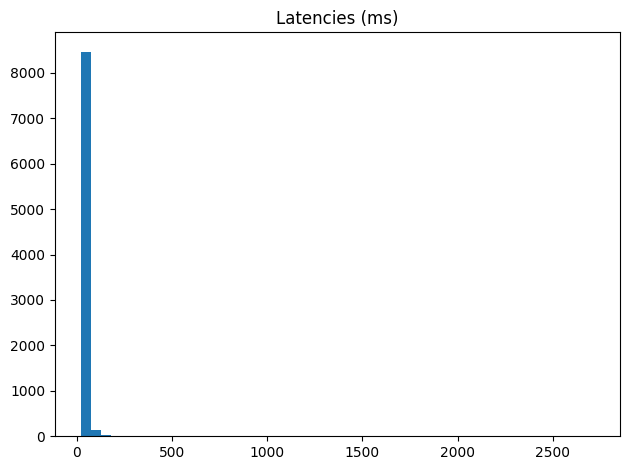

In [21]:
fig, axs = plt.subplots(1, tight_layout=True)
axs.hist(np.array(times)*1000, bins=50)
axs.set_title('Latencies (ms)')
print('Average latency:', np.mean(times)*1000, 'ms')
print('Average Command Rate:', 1/np.mean(times), 'Hz')
print('# of Samples:', len(times))

##### What do these results mean?

For high-speed cosimulation, we use dedicated and encrypted multiplexed gRPC channels which route cosimulator data directly into and out of a running simulation in the Sedaro cloud.  The latest generation of this interface has roughly 30ms round trip latency from our office in VA to our east coast cloud.  This allows for a ~33Hz command rate.

Given the multiplexed nature of this link, we can send many commands concurrently within the 33Hz cycle for transactions like telemetry requests and housekeeping functions, effectively achieving much higher command rates. Should you find that your latency be much higher than ~30ms, contact us and inquire about a platform deployment that is geographically closer to you.

Our team is happy to help write cosimulator middleware for your specific HIL/SIL application.  Reach out at support@sedarotech.com or drop a message in our [community Slack channel](https://join.slack.com/t/sedaro-community/shared_invite/zt-1jps4i711-mXy88AZQ9AV7YcEXr8x7Ow).